<a href="https://colab.research.google.com/github/lupinus-mami/colab-udemy-pystan/blob/main/pystan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# section 6

## 46.単回帰


物件価格を単回帰で求める
* param
    * N:物件数
    * a:傾き
    * b:切片
    * x:部屋の大きさ
    * y:物件価格
    * sigme:誤差
* 仮説
    * 物件価格yはax+bと表せる
    * yは正規分布している
* 統計モデル
    * y[n] ~ Normal(ax[n]+b, sigma)
    * つまりa,b,sigmaを求める1m

In [ ]:
  import pandas as pd
  import numpy as np
  import pystan
  import matplotlib.pyplot as plt
  %matplotlib inline

In [ ]:
plt.style.use('ggplot')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ベイズ統計学入門/data/real_estate1.xlsx')
display(df.head())

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


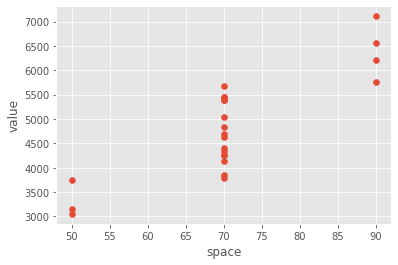

In [ ]:
plt.scatter(df['space'], df['value'])
plt.xlabel('space')
plt.ylabel('value')
plt.show()

In [ ]:
stan_model = """
data {
  int N;
  real x[N];
  real Y[N];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N){
    Y[n] ~ normal(a * x[n] + b, sigma);
  }
}
"""

In [ ]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8dbbfabb819d944de27a1d11f4ead273 NOW.


In [ ]:
stan_data = {'N' : df.shape[0], 'x' : df['space'], 'Y' : df['value']}

In [ ]:
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [ ]:
fit

Inference for Stan model: anon_model_8dbbfabb819d944de27a1d11f4ead273.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      77.96    0.32  11.81  55.66  70.03  77.63  85.38 102.24   1380    1.0
b     -691.7   23.07  847.9  -2453  -1219 -673.4 -119.0 883.25   1351    1.0
sigma 613.35    2.54 102.98  448.8 539.07 600.34 670.48 865.31   1640    1.0
lp__  -152.0    0.03   1.35 -155.4 -152.6 -151.6 -151.0 -150.5   1487    1.0

Samples were drawn using NUTS at Sun Oct 10 10:52:35 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

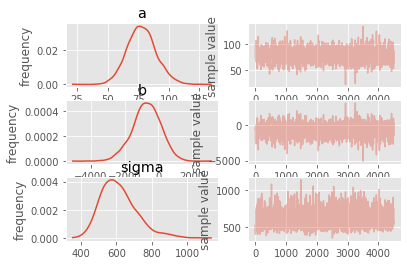

In [ ]:
fig = fit.plot()

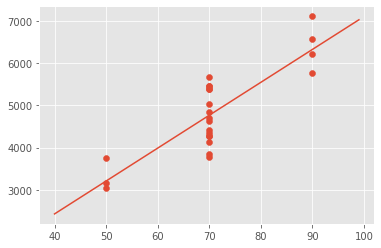

In [ ]:
a = 77.96
b = -691.7
x = np.arange(40, 100, 1)
y = a * x + b
plt.plot(x, y)
plt.scatter(df['space'], df['value'])
plt.show()

## 48.ベイズ信頼区間・予測区間

In [ ]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
from scipy.stats import mstats
%matplotlib inline

In [ ]:
plt.style.use('ggplot')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ベイズ統計学入門/data/real_estate1.xlsx')
display(df.head())

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


In [ ]:
stan_model = """
data {
  int N;
  real x[N];
  real Y[N];
  int N_s;
  real X_s[N_s];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N){
    Y[n] ~ normal(a * x[n] + b, sigma);
  }
}

generated quantities {
  real Y_s[N_s];
  for (n in 1:N_s){
    Y_s[n] = normal_rng(a * X_s[n] + b, sigma);
  }
}
"""

In [ ]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_10f0fda345230b1bb30800551f5ae606 NOW.


In [ ]:
X_s = np.arange(40, 90, 1)
N_s = X_s.shape[0]
stan_data = {'N' : df.shape[0], 'x' : df['space'], 'Y' : df['value'], 'N_s' : N_s, 'X_s' : X_s}

In [ ]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [ ]:
fit

Inference for Stan model: anon_model_10f0fda345230b1bb30800551f5ae606.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        78.11    0.33  11.85  53.99  70.44   78.3  86.06 100.49   1317    1.0
b       -701.0   23.45 848.04  -2300  -1261 -720.1 -160.8 1010.9   1308    1.0
sigma   614.41    2.58 104.23 452.19  541.9 599.32 670.19 862.44   1627    1.0
Y_s[1]  2429.5    12.9 720.54 1022.1 1958.2 2428.7 2910.3 3848.0   3122    1.0
Y_s[2]  2501.5   13.98 724.09 1070.1 2044.5 2495.2 2970.0 3996.0   2683    1.0
Y_s[3]  2577.8   13.53 728.53 1129.9 2104.0 2575.2 3049.9 4036.3   2899    1.0
Y_s[4]  2661.8   13.02 722.17 1284.9 2175.3 2655.2 3141.9 4061.1   3078    1.0
Y_s[5]  2735.3   12.59 714.66 1365.9 2256.0 2741.3 3211.1 4133.1   3222    1.0
Y_s[6]  2820.1   12.12 702.45 1413.5 2361.5 2813.0 3283.7 4179.2   3360    1.0
Y_s[7]  2888.6   12.52

In [ ]:
fit.extract('a')

OrderedDict([('a',
              array([76.6522497 , 75.02583173, 73.41362221, ..., 96.23822878,
                     84.90923043, 67.46528237]))])

In [ ]:
ms_a = fit.extract('a')['a']

(array([   7.,   64.,  268.,  796., 1401., 1257.,  567.,  121.,   13.,
           6.]), array([ 31.92072252,  41.56973874,  51.21875495,  60.86777117,
         70.51678738,  80.1658036 ,  89.81481982,  99.46383603,
        109.11285225, 118.76186846, 128.41088468]), <a list of 10 Patch objects>)

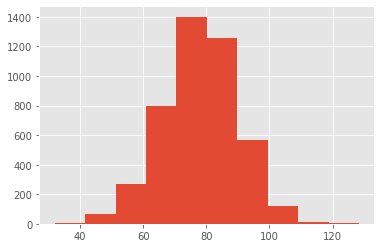

In [ ]:
plt.hist(ms_a)

In [ ]:
ms_b = fit.extract('b')['b']

In [ ]:
df_b = pd.DataFrame([])
for i in range(40, 90, 1):
  df_b[i] = ms_a * i + ms_b

In [ ]:
df_b.head()

,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,2343.929351,2420.581601,2497.233850,2573.886100,2650.538350,2727.190600,2803.842849,2880.495099,2957.147349,3033.799598,3110.451848,3187.104098,3263.756347,3340.408597,3417.060847,3493.713097,3570.365346,3647.017596,3723.669846,3800.322095,3876.974345,3953.626595,4030.278844,4106.931094,4183.583344,4260.235594,4336.887843,4413.540093,4490.192343,4566.844592,4643.496842,4720.149092,4796.801342,4873.453591,4950.105841,5026.758091,5103.410340,5180.062590,5256.714840,5333.367089,5410.019339,5486.671589,5563.323839,5639.976088,5716.628338,5793.280588,5869.932837,5946.585087,6023.237337,6099.889586
1,2681.357295,2756.383127,2831.408959,2906.434791,2981.460622,3056.486454,3131.512286,3206.538117,3281.563949,3356.589781,3431.615613,3506.641444,3581.667276,3656.693108,3731.718940,3806.744771,3881.770603,3956.796435,4031.822267,4106.848098,4181.873930,4256.899762,4331.925593,4406.951425,4481.977257,4557.003089,4632.028920,4707.054752,4782.080584,4857.106416,4932.132247,5007.158079,5082.183911,5157.209743,5232.235574,5307.261406,5382.287238,5457.313069,5532.338901,5607.364733,5682.390565,5757.416396,5832.442228,5907.468060,5982.493892,6057.519723,6132.545555,6207.571387,6282.597219,6357.623050
2,2556.329185,2629.742808,2703.156430,2776.570052,2849.983674,2923.397296,2996.810919,3070.224541,3143.638163,3217.051785,3290.465407,3363.879030,3437.292652,3510.706274,3584.119896,3657.533518,3730.947141,3804.360763,3877.774385,3951.188007,4024.601630,4098.015252,4171.428874,4244.842496,4318.256118,4391.669741,4465.083363,4538.496985,4611.910607,4685.324229,4758.737852,4832.151474,4905.565096,4978.978718,5052.392341,5125.805963,5199.219585,5272.633207,5346.046829,5419.460452,5492.874074,5566.287696,5639.701318,5713.114940,5786.528563,5859.942185,5933.355807,6006.769429,6080.183051,6153.596674
3,2925.553417,2991.500110,3057.446802,3123.393495,3189.340188,3255.286880,3321.233573,3387.180266,3453.126958,3519.073651,3585.020344,3650.967036,3716.913729,3782.860422,3848.807114,3914.753807,3980.700500,4046.647192,4112.593885,4178.540578,4244.487271,4310.433963,4376.380656,4442.327349,4508.274041,4574.220734,4640.167427,4706.114119,4772.060812,4838.007505,4903.954197,4969.900890,5035.847583,5101.794275,5167.740968,5233.687661,5299.634353,5365.581046,5431.527739,5497.474431,5563.421124,5629.367817,5695.314509,5761.261202,5827.207895,5893.154587,5959.101280,6025.047973,6090.994665,6156.941358
4,2921.653507,2984.732715,3047.811922,3110.891130,3173.970337,3237.049545,3300.128752,3363.207960,3426.287167,3489.366375,3552.445582,3615.524790,3678.603998,3741.683205,3804.762413,3867.841620,3930.920828,3994.000035,4057.079243,4120.158450,4183.237658,4246.316865,4309.396073,4372.475280,4435.554488,4498.633696,4561.712903,4624.792111,4687.871318,4750.950526,4814.029733,4877.108941,4940.188148,5003.267356,5066.346563,5129.425771,5192.504978,5255.584186,5318.663394,5381.742601,5444.821809,5507.901016,5570.980224,5634.059431,5697.138639,5760.217846,5823.297054,5886.376261,5949.455469,6012.534676


In [ ]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

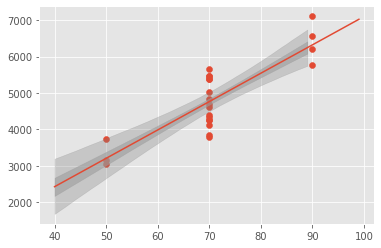

In [ ]:
a = 77.96
b = -691.7
x = np.arange(40, 100, 1)
y = a * x + b
plt.plot(x, y)
plt.scatter(df['space'], df['value'])
plt.fill_between(X_s, low_y50, high_y50, alpha=0.6, color='darkgray')
plt.fill_between(X_s, low_y95, high_y95, alpha=0.3, color='gray')
plt.show()

In [ ]:
  Y_p = fit.extract('Y_s')['Y_s']

In [ ]:
low_y, high_y = mstats.mquantiles(Y_p, [0.025, 0.975], axis=0)

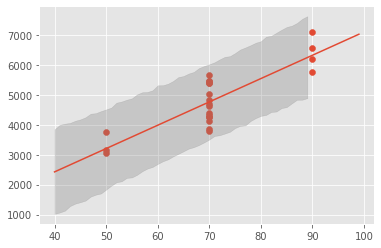

In [ ]:
a = 77.96
b = -691.7
x = np.arange(40, 100, 1)
y = a * x + b
plt.plot(x, y)
plt.scatter(df['space'], df['value'])
plt.fill_between(X_s, low_y, high_y, alpha=0.3, color='gray')
plt.show()

## 50.ロジスティック回帰

In [ ]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
from scipy.stats import mstats
%matplotlib inline

In [ ]:
plt.style.use('ggplot')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ベイズ統計学入門/data/dose_response.xlsx')
display(df.head())
# log10C : 薬の投与量
# death : マウスの生死

,log10 C,death
0,0.95,0
1,0.94,0
2,0.95,0
3,0.96,0
4,0.99,0


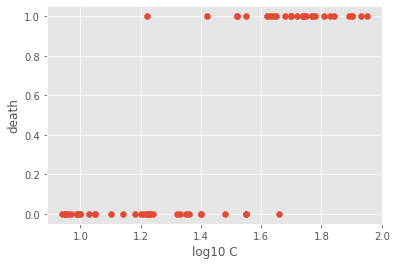

In [ ]:
plt.scatter(df['log10 C'], df['death'])
plt.xlabel('log10 C')
plt.ylabel('death')
plt.show()

In [ ]:
stan_model = '''
data {
  int N;
  real x[N];
  int<lower=0, upper=1> Y[N];
}

parameters {
  real a;
  real b;
}

model {
  for (n in 1:N){
    Y[n] ~ bernoulli_logit(a * x[n] + b);
  }
}
'''

In [ ]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_98588b8441306226b28c6808e6ddf8dd NOW.


In [ ]:
stan_data  = {'N' : df.shape[0], 'x' : df['log10 C'], 'Y' : df['death']}

In [ ]:
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [ ]:
fit

Inference for Stan model: anon_model_98588b8441306226b28c6808e6ddf8dd.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     13.74    0.14   3.39   8.31  11.28  13.28  15.87  21.55    615    1.0
b    -20.53    0.21   5.12 -32.19 -23.68 -19.84 -16.84 -12.28    620    1.0
lp__ -14.95    0.03   1.06  -17.8 -15.38 -14.62 -14.18 -13.89    926    1.0

Samples were drawn using NUTS at Sun Oct 10 13:21:37 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [ ]:
a, b = 13.74, -20.53

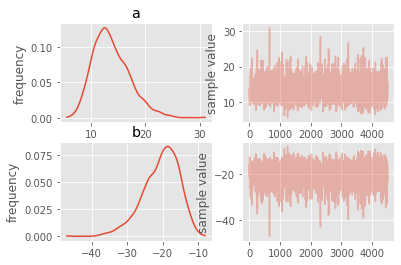

In [ ]:
fig = fit.plot()

In [ ]:
# ベイズ信頼区間
ms_a = fit.extract('a')['a']
ms_b = fit.extract('b')['b']
x = np.arange(1.0, 2.0, 0.01)
f = lambda x : 1.0 / (1 + np.exp(-x))
df_b = pd.DataFrame([])
for i in range(x.shape[0]):
  df_b[i] = f(ms_a * x[i] + ms_b)
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)
display(df_b.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.001117,0.001269,0.001441,0.001637,0.001860,0.002113,0.002400,0.002726,0.003097,0.003517,0.003995,0.004537,0.005152,0.005850,0.006641,0.007540,0.008558,0.009713,0.011023,0.012506,0.014186,0.016088,0.018241,0.020675,0.023427,0.026534,0.030042,0.033997,0.038451,0.043464,0.049096,0.055416,0.062496,0.070413,0.079249,0.089086,0.100013,0.112114,0.125476,0.140178,...,0.704560,0.730442,0.754845,0.777712,0.799014,0.818750,0.836943,0.853637,0.868889,0.882770,0.895359,0.906738,0.916995,0.926216,0.934485,0.941886,0.948497,0.954392,0.959641,0.964309,0.968454,0.972132,0.975392,0.978280,0.980835,0.983094,0.985092,0.986856,0.988414,0.989790,0.991003,0.992074,0.993018,0.993850,0.994584,0.995230,0.995800,0.996302,0.996744,0.997133
1,0.009853,0.010830,0.011904,0.013082,0.014376,0.015795,0.017352,0.019059,0.020931,0.022983,0.025230,0.027690,0.030384,0.033330,0.036551,0.040070,0.043913,0.048106,0.052678,0.057657,0.063076,0.068967,0.075363,0.082301,0.089815,0.097942,0.106718,0.116179,0.126360,0.137295,0.149015,0.161548,0.174918,0.189146,0.204244,0.220219,0.237073,0.254794,0.273366,0.292759,...,0.754990,0.772239,0.788613,0.804109,0.818731,0.832488,0.845398,0.857484,0.868771,0.879291,0.889074,0.898157,0.906574,0.914362,0.921557,0.928194,0.934311,0.939939,0.945114,0.949867,0.954228,0.958227,0.961890,0.965243,0.968312,0.971117,0.973681,0.976023,0.978161,0.980112,0.981892,0.983516,0.984996,0.986345,0.987575,0.988695,0.989715,0.990644,0.991489,0.992259
2,0.009061,0.009866,0.010743,0.011696,0.012733,0.013861,0.015086,0.016419,0.017867,0.019440,0.021149,0.023004,0.025018,0.027204,0.029574,0.032144,0.034930,0.037948,0.041215,0.044750,0.048573,0.052705,0.057167,0.061982,0.067174,0.072767,0.078787,0.085258,0.092208,0.099663,0.107649,0.116192,0.125318,0.135051,0.145415,0.156430,0.168115,0.180486,0.193556,0.207333,...,0.614133,0.634300,0.654007,0.673199,0.691828,0.709853,0.727239,0.743960,0.759993,0.775326,0.789950,0.803863,0.817067,0.829571,0.841387,0.852529,0.863015,0.872868,0.882108,0.890761,0.898851,0.906406,0.913450,0.920011,0.926115,0.931787,0.937054,0.941940,0.946467,0.950661,0.954541,0.958130,0.961447,0.964511,0.967340,0.969950,0.972358,0.974577,0.976623,0.978508
3,0.000435,0.000513,0.000605,0.000713,0.000841,0.000992,0.001169,0.001379,0.001626,0.001917,0.002259,0.002663,0.003139,0.003700,0.004361,0.005138,0.006054,0.007131,0.008399,0.009890,0.011643,0.013701,0.016118,0.018953,0.022275,0.026164,0.030711,0.036018,0.042203,0.049396,0.057740,0.067394,0.078527,0.091320,0.105957,0.122624,0.141497,0.162736,0.186471,0.212788,...,0.896115,0.910494,0.923054,0.933980,0.943449,0.951630,0.958680,0.964740,0.969939,0.974392,0.978200,0.981453,0.984228,0.986594,0.988609,0.990324,0.991783,0.993023,0.994077,0.994973,0.995734,0.996380,0.996929,0.997395,0.997790,0.998125,0.998410,0.998651,0.998856,0.999030,0.999177,0.999302,0.999408,0.999498,0.999574,0.999639,0.999694,0.999740,0.999780,0.999813
4,0.000129,0.000157,0.000191,0.000233,0.000283,0.000344,0.000419,0.000510,0.000620,0.000755,0.000918,0.001117,0.001358,0.001652,0.002010,0.002444,0.002972,0.003614,0.004394,0.005342,0.006492,0.007888,0.009581,0.011634,0.014120,0.017128,0.020763,0.025151,0.030436,0.036790,0.044411,0.053521,0.064375,0.077251,0.092447,0.110275,0.131045,0.155045,0.182517,0.213627,...,0.943569,0.953150,0.961172,0.967867,0.973439,0.978067,0.981903,0.985079,0.987704,0.989872,0.991661,0.993137,0.994352,0.995354,0.996178,0.996857,0.997415,0.997875,0.998253,0.998564,0.998819,0.999029,0.999202,0.999344,0.999461,0.999557,0.999636,0.999701,0.999754,0.999798,0.999834,0.999863,0.999888,0.999908,0.999924,0.999938,0.999949,0.999958,0.999965,0.999972


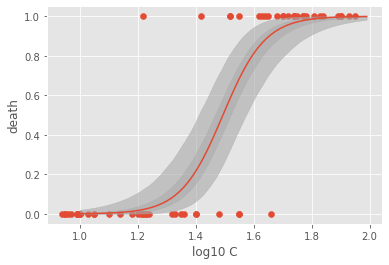

In [ ]:
plt.scatter(df['log10 C'], df['death'])
plt.fill_between(x, low_y50, high_y50, alpha=0.3, color='gray')
plt.fill_between(x, low_y95, high_y95, alpha=0.6, color='darkgray')
plt.plot(x, f(a*x+b))
plt.xlabel('log10 C')
plt.ylabel('death')
plt.show()

## 51.52.重回帰

仮説
- y = dx_1 + sx_2 + ex_3 +b
- yは式分布

統計モデル
- mu[n] = dx_1[n]  + sx_2[n]  + ex_3[n]  +b
- y[n] ~ Normal(mu[n], sigma)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy
from scipy.stats import mstats
import pystan
import seaborn as sns
%matplotlib inline

In [ ]:
plt.style.use('ggplot')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ベイズ統計学入門/data/real_estate2.xlsx')
display(df.head())

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


In [ ]:
# 前処理
df['elapsed'] = 2018 - df['value']

In [ ]:
dis_arr = df['distance'].unique()

In [ ]:
dis_arr

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [ ]:
dis_dict = {dis_arr[0] : 10
            , dis_arr[1] : 15
            , dis_arr[2] : 5
            , dis_arr[3] : 20
            , dis_arr[4] : 30
            , dis_arr[5] : np.nan}

In [ ]:
dis_dict

{'-': nan, 'バス': 30, '徒歩10分以内': 10, '徒歩15分以内': 15, '徒歩15分超': 20, '徒歩5分以内': 5}

In [ ]:
df['distance2'] = df['distance'].apply(lambda x: dis_dict[x])

In [ ]:
df = df.dropna()

In [ ]:
df2 = df[['space', 'elapsed', 'distance2', 'value']]
display(df2.head())

,space,elapsed,distance2,value
0,70,1108,10.0,910
1,70,898,10.0,1120
2,70,828,10.0,1190
3,70,828,10.0,1190
4,70,828,10.0,1190


In [ ]:
stan_model = '''
data {
  int N;
  real elapsed[N];
  real dis[N];
  real space[N];
  real Y[N];

}

parameters {
  real e;
  real d;
  real s;
  real b;
  real<lower=0> sigma;
}

model {
  real mu;
  for (i in 1:N){
    mu = e * elapsed[i] + d * dis[i] + s * space[i] + b;
    Y[i] ~ normal(mu, sigma);
  }
}
'''

In [ ]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc92d83b87ccdbac7a209bb4f8165911 NOW.


In [ ]:
stan_data = {
  'N' : df.shape[0],
  'elapsed' : df['elapsed'],
  'dis' : df['distance2'],
  'space' : df['space'],
  'Y' : df['value']
}

In [ ]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=8, seed=123)

In [ ]:
fit

Inference for Stan model: anon_model_fc92d83b87ccdbac7a209bb4f8165911.
8 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=12000.

         mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
e        -1.0  2.1e-8 3.7e-7    -1.0    -1.0    -1.0   -1.0   -1.0    313   1.03
d     -4.0e-6  6.3e-6 5.0e-5 -1.1e-4 -2.8e-5 -6.1e-6 1.7e-5 1.1e-4     61   1.16
s      3.1e-6  3.5e-6 2.8e-5 -5.3e-5 -1.0e-5 -6.9e-7 1.6e-5 6.7e-5     63   1.14
b      2018.0  2.5e-4 1.9e-3  2017.9  2018.0  2018.0 2018.0 2018.0     59   1.14
sigma  4.9e-3  2.0e-3 4.0e-3  1.6e-3  2.1e-3  4.0e-3 7.8e-3   0.01      4  42.36
lp__   1093.5   70.05 140.22   847.6  959.37  1081.9 1205.1 1258.2      4  28.91

Samples were drawn using NUTS at Sun Oct 10 14:30:58 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

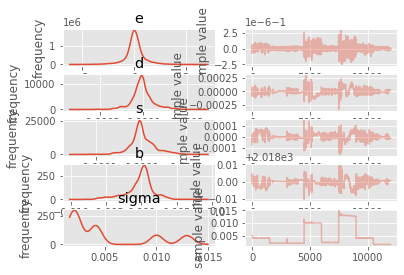

In [ ]:
fig = fit.plot()

収束しなかった

## 54.55.階層ベイズモデル

単回帰の場合
- 仮説
  - yは正規分布している
  - 身長はax+bと表せる
  - つまり共通の傾きaとb

階層ベイズモデル
- 仮説
  - 身長には個人差があり、a[i]x + b[i]と表せる
  - a[i] = a_0(全員共通) + a_id(個人差)
  - yと「個人差」は正規分布している(yと個人差それぞれ正規分布なので、階層化している)
-  統計モデル
  - Y[n] ~ Normal(a[n]x + b[n], sigma)
    - a[n] ~ a_0 + a_id[n]
    - bも
      - a_id[n] ~ Normal(0, sigma_a)
      - b_idも

In [ ]:
import pandas as pd
import numpy as np
import pystan
from scipy.stats import mstats
import matplotlib.pyplot as plt
import arviz
%matplotlib inline

In [ ]:
plt.style.use('ggplot')

In [ ]:
df =pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ベイズ統計学入門/data/multilevel_modeling.xlsx')
display(df.head())

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [ ]:
df.id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
groups = df.groupby(['id'])

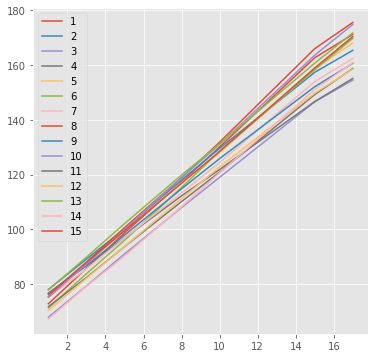

In [ ]:
plt.figure(figsize=(6, 6))
for name, group in groups:
  plt.plot(group['age'], group['height'], label=name)
plt.legend()

In [ ]:
stan_model = """
data {
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1, upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  for (id in 1:N_id){
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
  }
}
"""

In [ ]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af302aaa2a40dde4f7eba5ff4d4763d3 NOW.


In [ ]:
stan_data = {
    'N' : df.shape[0]
    , 'N_id' : 15
    , 'X' : df['age']
    , 'Y' : df['height']
    , 's_id' : df['id']
}

In [ ]:
fit = sm.sampling(data = stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [ ]:
fit

Inference for Stan model: anon_model_af302aaa2a40dde4f7eba5ff4d4763d3.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  5.6e-3   0.12   5.53   5.69   5.76   5.84   6.01    444   1.01
b0        68.22    0.04   0.96  66.27  67.61  68.22  68.84  70.16    646   1.01
a_id[1]    0.47  5.6e-3   0.13   0.21   0.39   0.47   0.55   0.72    542   1.01
a_id[2]   -0.19  5.7e-3   0.13  -0.46  -0.27  -0.19  -0.11   0.07    535   1.01
a_id[3]   -0.29  5.6e-3   0.13  -0.55  -0.37  -0.29  -0.21  -0.03    551   1.01
a_id[4]    -0.8  5.5e-3   0.13  -1.06  -0.88  -0.79  -0.71  -0.54    564   1.01
a_id[5]    0.09  5.7e-3   0.13  -0.17 6.0e-3   0.09   0.17   0.35    517   1.01
a_id[6]    0.41  5.4e-3   0.13   0.15   0.33   0.41   0.49   0.67    566   1.01
a_id[7]   -0.21  5.3e-3   0.13  -0.47  -0.29  -0.21  -0.12   0.05    609   1.01
a_id[8]    

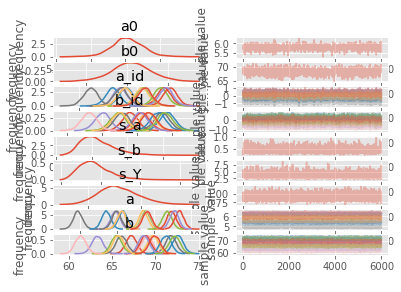

In [ ]:
fig = fit.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb1c9fcf10>,
      dtype=object)

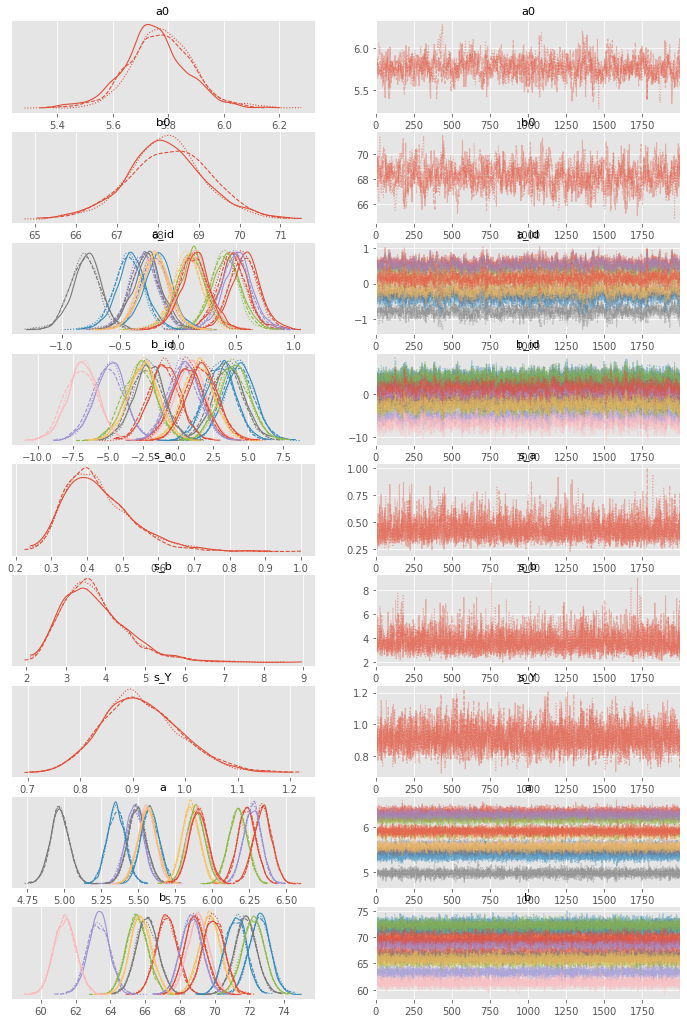

In [ ]:
arviz.plot_trace(fit)

In [ ]:
# ベイズ信頼区間 id = 1のみ
ms_a = fit.extract('a')['a']
ms_b = fit.extract('b')['b']


In [ ]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
  df_b[i] = ms_a[:,0] * x[i] + ms_b[:, 0]
  

In [ ]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [ ]:
df_0 = groups.get_group(1)

In [ ]:
df_0.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


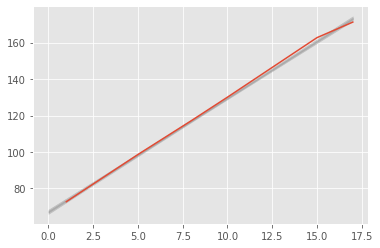

In [ ]:
plt.plot(df_0['age'], df_0['height'])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color='darkgray')
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color='gray')

## 56.57.状態空間モデル

地球温暖化の予測を行う
- data
  - x : 時間[年]
  - y : 気温の相対値[℃]
- 事前知識
  - 気温はある変化幅で推移している
- 状態空間モデルとは
  - 時系列データは何かしたの法則に従って変化している
  - 次の状態(mu[t+1])　＝ 今の状態(mu[t])　＋ 法則性による変化(e[t])
- 仮説
  - 気温はある法則で時間変化する
  - 測定気温は正規分布している
- 統計モデル
  - mu[n] = mu[n-1] + e[n]
  - e[n] ~ Normal(0, sigma_mu)
  - y[n] ~ Normal(mu[n], sigma)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
from scipy.stats import mstats
%matplotlib inline

In [ ]:
plt.style.use('ggplot')

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ベイズ統計学入門/data/temperature_series.xlsx')

In [ ]:
df.head()

,x,y
0,1891,-0.6291
1,1892,-0.7111
2,1893,-0.7520
3,1894,-0.7008
4,1895,-0.6752


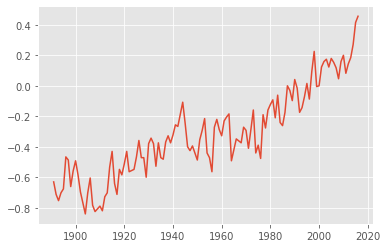

In [ ]:
plt.plot(df['x'], df['y'])
plt.show()

In [ ]:
stan_model = '''
data {
  int T;
  int T_new;
  real Y[T];
}

parameters {
  real mu[T];
  real<lower=0> s_mu;
  real<lower=0> s_Y;
}

model {
  for (t in 2:T){
    mu[t] ~ normal(mu[t-1], s_mu);
  }

  for (t in 1:T){
    Y[t] ~ normal(mu[t], s_Y);
  }
}

generated quantities {
  real mu_new;
  real Y_new[T+T_new];
  for (t in 1:T){
    Y_new[t] = normal_rng(mu[t], s_Y);
  }
  mu_new = normal_rng(mu[T], s_mu);
  Y_new[T+T_new] = normal_rng(mu_new, s_Y);
}
'''

In [ ]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e20eb9e969c926b70022d5ed4d048707 NOW.


In [ ]:
stan_data = {'T' : df.shape[0], 'T_new' : 1, 'Y' : df['y']}

In [ ]:
fit = sm.sampling(data=stan_data, iter=3000, warmup=1500, chains=3, seed=123)

In [ ]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_e20eb9e969c926b70022d5ed4d048707.
3 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

         mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
mu[1]   -0.66  8.1e-4   0.05  -0.76  -0.69  -0.66  -0.63   -0.55   4317    1.0
mu[2]   -0.69  7.8e-4   0.05  -0.78  -0.72  -0.69  -0.66    -0.6   3573    1.0
mu[3]    -0.7  1.3e-3   0.05  -0.79  -0.73   -0.7  -0.67   -0.61   1225    1.0
mu[4]   -0.68  1.0e-3   0.05  -0.77  -0.71  -0.68  -0.65   -0.59   1981    1.0
mu[5]   -0.63  7.7e-4   0.04  -0.72  -0.66  -0.63  -0.61   -0.55   3161    1.0
mu[6]   -0.55  1.7e-3   0.05  -0.65  -0.59  -0.55  -0.52   -0.45    879    1.0
mu[7]   -0.55  1.4e-3   0.05  -0.64  -0.58  -0.55  -0.51   -0.45   1231    1.0
mu[8]   -0.59  9.0e-4   0.05  -0.69  -0.62  -0.59  -0.56    -0.5   2817    1.0
mu[9]   -0.57  8.6e-4   0.05  -0.66   -0.6  -0.57  -0.54   -